# Modeling NHL Expected Goals

In [105]:
# Standard Packages
import pandas as pd
import numpy as np
import warnings
import re

# Viz Packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

# Modeling Packages
## Modeling Prep
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, \
GridSearchCV, RandomizedSearchCV

## SKLearn Data Prep Modules
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, \
PolynomialFeatures, PowerTransformer, Normalizer, MaxAbsScaler

from sklearn.impute import SimpleImputer

## SKLearn Classification Models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor, AdaBoostClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


## SKLearn Pipeline Setup
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## SKLearn Model Optimization
from sklearn.feature_selection import RFE, f_regression

## Boosting
from xgboost import XGBRegressor
from xgboost import XGBClassifier

## SKLearn Metrics
### Classification Scoring/Evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, \
ConfusionMatrixDisplay, log_loss, confusion_matrix, RocCurveDisplay, make_scorer, roc_auc_score

In [106]:
# Notebook Config
## Suppress Python Warnings (Future, Deprecation)
warnings.filterwarnings("ignore", category= FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Suppress Pandas Warnings (SettingWithCopy)
pd.options.mode.chained_assignment = None

## Pandas Display Config
pd.options.display.max_columns = None
pd.options.display.width = None

## Display SKLearn estimators as diagrams
from sklearn import set_config
set_config(display= 'diagram')

## EDA

In [107]:
# Use 2021-22 data - most recent full season
s21_shots_df = pd.read_csv('project-data/shots_2021.csv')
s21_shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.400000,0,0,0,5,PIT,0,33.4,37.0,25.0,31.000000,25.000000,25.0,2,3,37,37,25,31,25,25,31,37,25,31,25,25,13.038405,SHOT,20001,0,8477465,Tristan Jarry,0,0,0,5,TBL,0,0,10,1.0,0,HIT,0.0,0.0,HOME,50,50,-39,-39,AWAYZONE,0,1,91,0,C,2021,R,Steven Stamkos,8474564.0,34,25,22.000000,4.0,4.0,34.000000,25.0,16.600000,2,3,34,4,4,34,25,25,4,4,4,34,25,4,-48.814075,48.814075,0.000000,0.000000,0,42.520583,0,1,0,0,0,0,0,0,WRIST,1.0,1.303840,HOME,TBL,63,-21,25,10,0,61,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.400000,0,0,0,5,PIT,0,3.2,8.0,8.0,0.000000,0.000000,3.2,2,3,8,8,8,0,0,8,0,8,8,0,0,0,130.080744,SHOT,20001,0,8476883,Andrei Vasilevskiy,0,0,0,5,TBL,0,0,15,0.0,0,BLOCK,0.0,0.0,HOME,60,-60,-17,17,HOMEZONE,1,1,23,0,L,2021,L,Brock McGinn,8476934.0,41,41,24.600000,0.0,0.0,41.000000,41.0,24.600000,2,3,41,0,0,41,41,41,0,0,0,41,41,0,-38.367485,38.367485,38.367485,2.019341,0,30.610456,0,0,0,0,1,0,0,0,WRIST,1.0,6.846355,AWAY,PIT,104,0,41,19,13,-65,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2

The dataset has 121,471 rows of shot instances and 124 columns

In [108]:
# Check the numeric column stats
s21_shots_df.describe()

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,game_id,goal,goalieIdForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventShotAngle,lastEventShotDistance,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,season,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotWasOnGoal,speedFromLastEvent,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
count,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,1.214710e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.0,1.214680e+05,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.000000,121471.00000

Lots of numeric features of differing units/magnitude - data will require scaling

In [109]:
# Check data types and non-null counts
s21_shots_df.info(verbose=True, show_counts=True) # data is rather robust and clean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121471 entries, 0 to 121470
Data columns (total 124 columns):
 #    Column                                                 Non-Null Count   Dtype  
---   ------                                                 --------------   -----  
 0    shotID                                                 121471 non-null  int64  
 1    arenaAdjustedShotDistance                              121471 non-null  float64
 2    arenaAdjustedXCord                                     121471 non-null  float64
 3    arenaAdjustedXCordABS                                  121471 non-null  float64
 4    arenaAdjustedYCord                                     121471 non-null  float64
 5    arenaAdjustedYCordAbs                                  121471 non-null  float64
 6    averageRestDifference                                  121471 non-null  float64
 7    awayEmptyNet                                           121471 non-null  int64  
 8    awayPenalty1Length    

In [110]:
# Check event types to make sure all rows are shots. Valid event values for shots are SHOT, MISS, GOAL
s21_shots_df['event'].value_counts() # all events are shots

SHOT    80180
MISS    32594
GOAL     8697
Name: event, dtype: int64

In [111]:
# check if postseason included
s21_shots_df['isPlayoffGame'].value_counts() # playoff games are included in the dataset

0    113158
1      8313
Name: isPlayoffGame, dtype: int64

In [112]:
# Check period column in case shootout attempts are included
s21_shots_df['period'].value_counts()

2    41584
1    39317
3    38793
4     1716
5       47
6       14
Name: period, dtype: int64

In [113]:
# Check how many extra periods are attributable to the post season
len(s21_shots_df.loc[(s21_shots_df['period'] >= 5) & (s21_shots_df['isPlayoffGame'] == 1)])

61

All instances of a 5th and 6th period are attributable to the post season, so shootouts have already been scrubbed

In [114]:
# Summarize missing data
pd.set_option('display.max_rows', 125)
s21_shots_df.isna().sum()

shotID                                                     0
arenaAdjustedShotDistance                                  0
arenaAdjustedXCord                                         0
arenaAdjustedXCordABS                                      0
arenaAdjustedYCord                                         0
arenaAdjustedYCordAbs                                      0
averageRestDifference                                      0
awayEmptyNet                                               0
awayPenalty1Length                                         0
awayPenalty1TimeLeft                                       0
awaySkatersOnIce                                           0
awayTeamCode                                               0
awayTeamGoals                                              0
defendingTeamAverageTimeOnIce                              0
defendingTeamAverageTimeOnIceOfDefencemen                  0
defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff      0
defendingTeamAverageTime

Features with missing values and counts
- goalieNameForShot                                        800
  - these probably are not missing, but indicative of empty net situations
- playerPositionThatDidEvent                                 4
- shooterLeftRight                                           3
- shooterName                                                3
- shooterPlayerId                                            3
- shotType                                                   5

Inspect shotType as other columns will be dropped

In [115]:
# Check shotType values
print(s21_shots_df['shotType'].value_counts())
print(s21_shots_df['shotType'].isna().sum())

WRIST    68003
SLAP     16413
SNAP     15529
BACK      8985
TIP       8404
DEFL      3129
WRAP      1003
Name: shotType, dtype: int64
5


In [116]:
# Drill down on rows missing shotType values
s21_shots_df[s21_shots_df['shotType'].isna()] # Drop these rows with NaN shotType values

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
27087,27087,23.000000,-66.0,66.0,2.0,2.0,1.333333,0,0,0,5,MTL,4,72.333333,84.0,22.0,70.000000,20.400000,20.666667,1,5,84,84,22,84,22,22,14,84,22,14,14,14,66.030296,GOAL,20319,1,0,NaN,1,0,0,6,PIT,3,0,341,0.0,0,FAC,0.000000,0.000000,AWAY,0,0,0,0,HOMEZONE,0,3,17,0,R,2021,R,Josh Anderson,8476981.0,22,22,22.0,22.0,22.0,22.000000,22.000000,22.0,2,3,22,22,22,22,22,22,22,22,22,22,22,22,-4.969741,4.969741,0.000000,0.000000,0,23.086793,0,0,1,0,0,0,0,0,NaN,1.0,3.001377,AWAY,MTL,3552,8,22,22,0,-66,66,0.008195,0.878555,0.052515,0.042078,0.004915,0.013741,0.646972,2,-2
31300,31300,7.071068,-82.0,82.0,1.0,1.0,0.000000,0,0,0,5,COL,2,24.000000,24.0,24.0,24.000000,24.000000,24.000000,2,3,24,24,24,24,24,24,24,24,24,24,24,24,165.656271,GOAL,20368,1,8477992,Jonas Johansson,0,0,0,5,OTT,2,1,138,1.0,0,HIT,0.000000,0.000000,AWAY,79,-79,-38,38,AWAYZONE,1,2,18,0,L,2021,L,Tim Stutzle,8482116.0,25,24,24.2,24.0,24.0,24.333333,24.000000,24.0,2,3,25,24,24,25,24,24,24,24,24,24,24,24,-8.130102,8.130102,0.000000,0.000000,0,7.071068,0,0,0,0,0,0,0,0,NaN,1.0,41.414068,HOME,OTT,1273,0,24,4,0,-82,82,0.154786,0.262797,0.267382,0.186394,0

In [117]:
# Drop the 5 rows missing shot type data
s21_shots_df = s21_shots_df.dropna(subset=['shotType'])
s21_shots_df

,shotID,arenaAdjustedShotDistance,arenaAdjustedXCord,arenaAdjustedXCordABS,arenaAdjustedYCord,arenaAdjustedYCordAbs,averageRestDifference,awayEmptyNet,awayPenalty1Length,awayPenalty1TimeLeft,awaySkatersOnIce,awayTeamCode,awayTeamGoals,defendingTeamAverageTimeOnIce,defendingTeamAverageTimeOnIceOfDefencemen,defendingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,defendingTeamAverageTimeOnIceOfForwards,defendingTeamAverageTimeOnIceOfForwardsSinceFaceoff,defendingTeamAverageTimeOnIceSinceFaceoff,defendingTeamDefencemenOnIce,defendingTeamForwardsOnIce,defendingTeamMaxTimeOnIce,defendingTeamMaxTimeOnIceOfDefencemen,defendingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMaxTimeOnIceOfForwards,defendingTeamMaxTimeOnIceOfForwardsSinceFaceoff,defendingTeamMaxTimeOnIceSinceFaceoff,defendingTeamMinTimeOnIce,defendingTeamMinTimeOnIceOfDefencemen,defendingTeamMinTimeOnIceOfDefencemenSinceFaceoff,defendingTeamMinTimeOnIceOfForwards,defendingTeamMinTimeOnIceOfForwardsSinceFaceoff,defendingTeamMinTimeOnIceSinceFaceoff,distanceFromLastEvent,event,game_id,goal,goalieIdForShot,goalieNameForShot,homeEmptyNet,homePenalty1Length,homePenalty1TimeLeft,homeSkatersOnIce,homeTeamCode,homeTeamGoals,homeTeamWon,id,isHomeTeam,isPlayoffGame,lastEventCategory,lastEventShotAngle,lastEventShotDistance,lastEventTeam,lastEventxCord,lastEventxCord_adjusted,lastEventyCord,lastEventyCord_adjusted,location,offWing,period,playerNumThatDidEvent,playerNumThatDidLastEvent,playerPositionThatDidEvent,season,shooterLeftRight,shooterName,shooterPlayerId,shooterTimeOnIce,shooterTimeOnIceSinceFaceoff,shootingTeamAverageTimeOnIce,shootingTeamAverageTimeOnIceOfDefencemen,shootingTeamAverageTimeOnIceOfDefencemenSinceFaceoff,shootingTeamAverageTimeOnIceOfForwards,shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff,shootingTeamAverageTimeOnIceSinceFaceoff,shootingTeamDefencemenOnIce,shootingTeamForwardsOnIce,shootingTeamMaxTimeOnIce,shootingTeamMaxTimeOnIceOfDefencemen,shootingTeamMaxTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMaxTimeOnIceOfForwards,shootingTeamMaxTimeOnIceOfForwardsSinceFaceoff,shootingTeamMaxTimeOnIceSinceFaceoff,shootingTeamMinTimeOnIce,shootingTeamMinTimeOnIceOfDefencemen,shootingTeamMinTimeOnIceOfDefencemenSinceFaceoff,shootingTeamMinTimeOnIceOfForwards,shootingTeamMinTimeOnIceOfForwardsSinceFaceoff,shootingTeamMinTimeOnIceSinceFaceoff,shotAngle,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotAngleReboundRoyalRoad,shotDistance,shotGeneratedRebound,shotGoalieFroze,shotOnEmptyNet,shotPlayContinuedInZone,shotPlayContinuedOutsideZone,shotPlayStopped,shotRebound,shotRush,shotType,shotWasOnGoal,speedFromLastEvent,team,teamCode,time,timeDifferenceSinceChange,timeSinceFaceoff,timeSinceLastEvent,timeUntilNextEvent,xCord,xCordAdjusted,xFroze,xGoal,xPlayContinuedInZone,xPlayContinuedOutsideZone,xPlayStopped,xRebound,xShotWasOnGoal,yCord,yCordAdjusted
0,0,42.520583,61.0,61.0,-32.0,32.0,-8.400000,0,0,0,5,PIT,0,33.4,37.0,25.0,31.000000,25.000000,25.0,2,3,37,37,25,31,25,25,31,37,25,31,25,25,13.038405,SHOT,20001,0,8477465,Tristan Jarry,0,0,0,5,TBL,0,0,10,1.0,0,HIT,0.0,0.0,HOME,50,50,-39,-39,AWAYZONE,0,1,91,0,C,2021,R,Steven Stamkos,8474564.0,34,25,22.000000,4.0,4.0,34.000000,25.0,16.600000,2,3,34,4,4,34,25,25,4,4,4,34,25,4,-48.814075,48.814075,0.000000,0.000000,0,42.520583,0,1,0,0,0,0,0,0,WRIST,1.0,1.303840,HOME,TBL,63,-21,25,10,0,61,61,0.202514,0.009192,0.445979,0.289830,0.023891,0.028594,0.718082,-32,-32
1,1,30.610456,-65.0,65.0,19.0,19.0,21.400000,0,0,0,5,PIT,0,3.2,8.0,8.0,0.000000,0.000000,3.2,2,3,8,8,8,0,0,8,0,8,8,0,0,0,130.080744,SHOT,20001,0,8476883,Andrei Vasilevskiy,0,0,0,5,TBL,0,0,15,0.0,0,BLOCK,0.0,0.0,HOME,60,-60,-17,17,HOMEZONE,1,1,23,0,L,2021,L,Brock McGinn,8476934.0,41,41,24.600000,0.0,0.0,41.000000,41.0,24.600000,2,3,41,0,0,41,41,41,0,0,0,41,41,0,-38.367485,38.367485,38.367485,2.019341,0,30.610456,0,0,0,0,1,0,0,0,WRIST,1.0,6.846355,AWAY,PIT,104,0,41,19,13,-65,65,0.285948,0.031353,0.303080,0.325607,0.026384,0.027629,0.793188,19,-19
2

In [118]:
# Check values of the target variable goal
s21_shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112773
1      8693
Name: goal, dtype: int64

In [119]:
# check goal imbalance
s21_shots_df['goal'].value_counts(normalize=True) # very imbalanced

0    0.928433
1    0.071567
Name: goal, dtype: float64

Imbalance will have to be addressed with oversampling or subsetting of data 

## Visualize Shot Types & Goals

In [120]:
shots_df.goal.value_counts(normalize=True) # Baseline will predict no goal scord 92.8% of the time

0    0.928436
1    0.071564
Name: goal, dtype: float64

In [ ]:
# Create goals DF
goals_df = s21_shots_df['goal'].value_counts().rename_axis('Shot Type').reset_index(name='Shots Taken')
shot_types_df['Shot Type % of Shots Taken'] = shot_types_df['Shots Taken'] / shot_types_df['Shots Taken'].sum()
shot_types_df

<AxesSubplot: xlabel='goal', ylabel='count'>

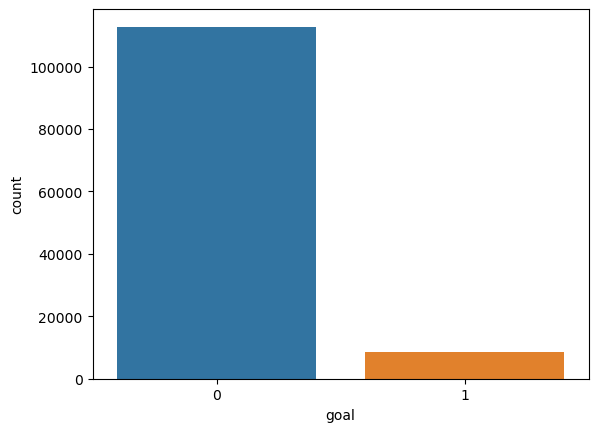

In [121]:
# Vizualize target variable distribution
sns.countplot(x='goal', data=shots_df)

In [122]:
# Random choice accuracy score
baseline_pred = np.ones(shots_df.shape[0])
accuracy_score(shots_df['goal'],baseline_pred)

0.07156383276523572

In [123]:
# Random choice log loss as that is the industry standard metric for xG models
baseline_probs = np.repeat(shots_df['goal'].value_counts(normalize=True)[1], shots_df.shape[0])
log_loss(shots_df['goal'], baseline_probs)

0.25766544118178614

In [125]:
# Create shots taken by shotType DF
shot_types_df = s21_shots_df['shotType'].value_counts().rename_axis('Shot Type').reset_index(name='Shots Taken')
shot_types_df['Shot Type % of Shots Taken'] = shot_types_df['Shots Taken'] / shot_types_df['Shots Taken'].sum()
shot_types_df

,Shot Type,Shots Taken,Shot Type % of Shots Taken
0,WRIST,68003,0.559852
1,SLAP,16413,0.135124
2,SNAP,15529,0.127846
3,BACK,8985,0.073971
4,TIP,8404,0.069188
5,DEFL,3129,0.025760
6,WRAP,1003,0.008257


In [126]:
# Create df for goal shot types
goals_scored = s21_shots_df['goal'] == 1
goals_by_type = goals_scored.groupby(s21_shots_df['shotType']).sum().rename_axis('Shot Type').reset_index(name='Goals Scored')
goals_by_type['Shot Type % of Goals Scored'] = goals_by_type['Goals Scored'] / goals_by_type['Goals Scored'].sum()
goals_by_type

,Shot Type,Goals Scored,Shot Type % of Goals Scored
0,BACK,834,0.095939
1,DEFL,280,0.032210
2,SLAP,829,0.095364
3,SNAP,1356,0.155988
4,TIP,804,0.092488
5,WRAP,43,0.004947
6,WRIST,4547,0.523065


In [127]:
# Merge the goals scored df into shots taken
shot_types_df = shot_types_df.merge(goals_by_type, on='Shot Type', how='inner')
shot_types_df

,Shot Type,Shots Taken,Shot Type % of Shots Taken,Goals Scored,Shot Type % of Goals Scored
0,WRIST,68003,0.559852,4547,0.523065
1,SLAP,16413,0.135124,829,0.095364
2,SNAP,15529,0.127846,1356,0.155988
3,BACK,8985,0.073971,834,0.095939
4,TIP,8404,0.069188,804,0.092488
5,DEFL,3129,0.025760,280,0.032210
6,WRAP,1003,0.008257,43,0.004947


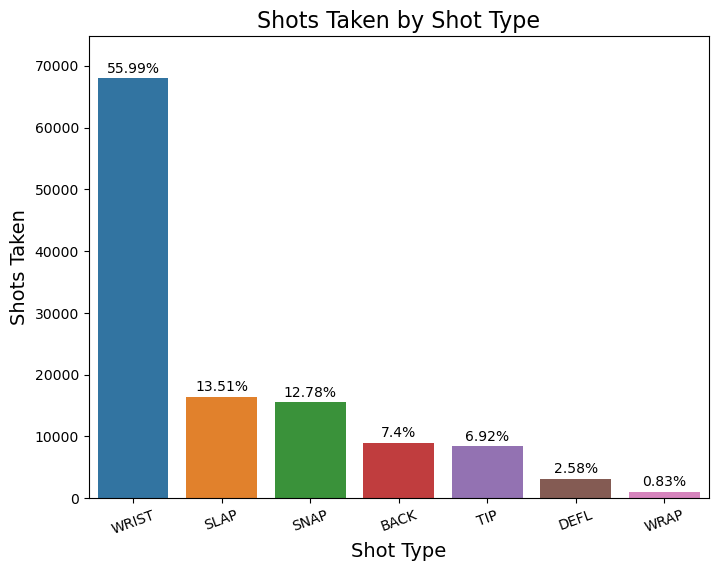

In [128]:
shots_labels = np.round((shot_types_df['Shot Type % of Shots Taken'] * 100),2).astype(str) + '%'

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x='Shot Type', y='Shots Taken', data=shot_types_df)
ax.bar_label(ax.containers[0], labels=shots_labels, padding=2)
ax.margins(y=0.1)
# ax.margins(x=0.05)
plt.title("Shots Taken by Shot Type", size = 16)
plt.xlabel("Shot Type", size = 14)
plt.xticks(rotation=20)
plt.ylabel("Shots Taken", size = 14)
plt.show()

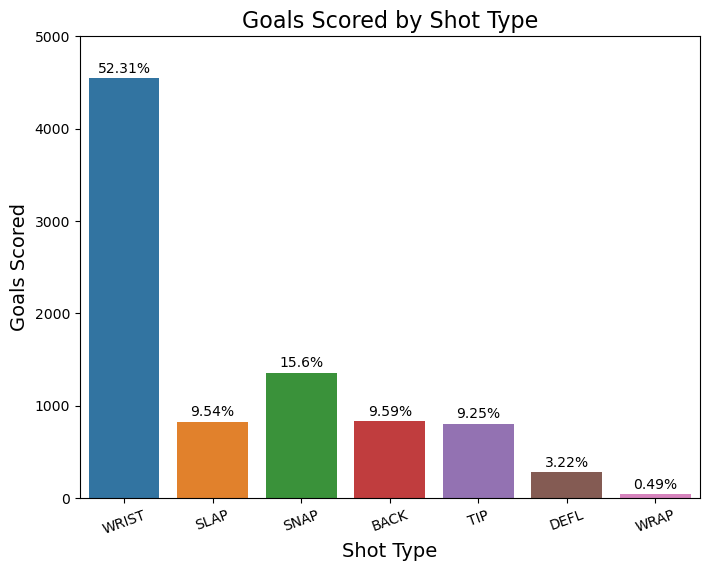

In [129]:
goals_labels = np.round((shot_types_df['Shot Type % of Goals Scored'] * 100),2).astype(str) + '%'

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x='Shot Type', y='Goals Scored', data=shot_types_df)
ax.bar_label(ax.containers[0], labels=goals_labels, padding=2)
ax.margins(y=0.1)
# ax.margins(x=0.05)
plt.title("Goals Scored by Shot Type", size = 16)
plt.xlabel("Shot Type", size = 14)
plt.xticks(rotation=20)
plt.ylabel("Goals Scored", size = 14)
plt.show()

## Feature Engineering

In [130]:
# Features from dataset to be included model
cols_to_keep = (pd.read_csv('project-data/feature-list.csv', header=None))
cols_to_keep = cols_to_keep[0].to_list()
cols_to_keep

['homeSkatersOnIce',
 'awaySkatersOnIce',
 'isHomeTeam',
 'shotType',
 'shotRush',
 'arenaAdjustedShotDistance',
 'arenaAdjustedXCordABS',
 'arenaAdjustedYCordAbs',
 'shotAngleAdjusted',
 'shotAnglePlusRebound',
 'shotAnglePlusReboundSpeed',
 'shotOnEmptyNet',
 'timeSinceLastEvent',
 'distanceFromLastEvent',
 'lastEventxCord_adjusted',
 'lastEventyCord_adjusted',
 'speedFromLastEvent',
 'offWing',
 'goal']

In [131]:
# New df with unnecessary columns dropped and index reset
shots_df = s21_shots_df[cols_to_keep].reset_index(drop=True)
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0


### Add Game Strength State Variable

Takes the number of players on the ice for each team (homeSkatersOnIce & awaySkatersOnIce) to derive even strength, powerplay, and shorthanded game states

In [132]:
# add column for game_strength_state
shots_df['game_strength_state'] = ''

In [133]:
# Add even strength game state values
shots_df.loc[(shots_df['homeSkatersOnIce'] == 3) & (shots_df['awaySkatersOnIce'] == 3), 
             'game_strength_state'] = 'EV3'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 4) & (shots_df['awaySkatersOnIce'] == 4), 
             'game_strength_state'] = 'EV4'
shots_df.loc[(shots_df['homeSkatersOnIce'] == 5) & (shots_df['awaySkatersOnIce'] == 5), 
             'game_strength_state'] = 'EV5'
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,


In [134]:
# Add Home team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'PP_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 3), 'game_strength_state'] = 'PP_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] == 6) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_6v4'

In [135]:
# Add Away team game_strength_state
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_5v4'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 5), 'game_strength_state'] = 'PP_5v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 3) & 
       (shots_df['awaySkatersOnIce'] == 4), 'game_strength_state'] = 'PP_4v3'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 5) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'PP_6v5'

shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['homeSkatersOnIce'] == 4) & 
       (shots_df['awaySkatersOnIce'] == 6), 'game_strength_state'] = 'PP_6v4'

In [136]:
# Add shorthandeed game_strength_state
# Binning all man down strength states into one shorthanded, 'SH', bucket
shots_df.loc[(shots_df['isHomeTeam'] == 1) & (shots_df['homeSkatersOnIce'] < shots_df['awaySkatersOnIce']),
             'game_strength_state'] = 'SH'
shots_df.loc[(shots_df['isHomeTeam'] == 0) & (shots_df['awaySkatersOnIce'] < shots_df['homeSkatersOnIce']),
             'game_strength_state'] = 'SH'

In [137]:
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,PP_6v5


In [138]:
# Check game_strength_state value counts to ensure proper encoding
print(shots_df['game_strength_state'].value_counts())
# Also check normalized count formatted as a percentage
print(shots_df['game_strength_state'].value_counts(normalize=True).mul(100).round(1).astype(str) + '0%')

EV5       95454
PP_5v4    16058
SH         3900
PP_6v5     2137
EV4        1495
EV3        1322
PP_5v3      535
PP_6v4      294
PP_4v3      263
              8
Name: game_strength_state, dtype: int64
EV5       78.60%
PP_5v4    13.20%
SH         3.20%
PP_6v5     1.80%
EV4        1.20%
EV3        1.10%
PP_5v3     0.40%
PP_6v4     0.20%
PP_4v3     0.20%
           0.00%
Name: game_strength_state, dtype: object


8 situations are unencoded. These must be strength state situations such as 6 on 3, which are very rare. These unencoded situations are so infrequent, they make up less than .00% of the data

In [139]:
# Given the rarity of 6v3 states, best to drop those 8 rows
shots_df = shots_df.loc[shots_df['game_strength_state'] != '']
shots_df

,homeSkatersOnIce,awaySkatersOnIce,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,5,5,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,5,5,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,5,5,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,5,5,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,5,5,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,5,5,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,5,5,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,5,5,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,6,5,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,PP_6v5


In [140]:
# Drop homeSkatersOnIce & awaySkatersOnIce now that we have derived strength states
shots_df = shots_df.drop(['homeSkatersOnIce', 'awaySkatersOnIce'], axis=1)
shots_df

,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,1.0,WRIST,0,42.520583,61.0,32.0,48.814075,0.000000,0.000000,0,10,13.038405,50,-39,1.303840,0,0,EV5
1,0.0,WRIST,0,30.610456,65.0,19.0,38.367485,38.367485,2.019341,0,19,130.080744,-60,17,6.846355,1,0,EV5
2,1.0,WRIST,0,85.381497,8.0,27.0,18.434949,0.000000,0.000000,0,4,60.415230,67,40,15.103807,1,0,EV5
3,0.0,WRIST,0,29.274562,60.0,4.0,7.853313,0.000000,0.000000,0,2,19.723083,70,-13,9.861541,0,0,EV5
4,1.0,WRIST,0,26.305893,63.0,4.0,8.746162,0.000000,0.000000,0,19,134.536240,-69,-22,7.080855,0,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121461,1.0,SNAP,0,30.463092,61.0,12.0,23.198591,0.000000,0.000000,0,11,12.806248,69,-22,1.164204,1,0,EV5
121462,1.0,TIP,0,16.278821,73.0,3.0,10.619655,0.000000,0.000000,0,12,58.600341,20,22,4.883362,1,0,EV5
121463,0.0,SNAP,0,41.194660,48.0,4.0,5.572198,0.000000,0.000000,0,16,26.076810,74,-2,1.629801,1,0,EV5
121464,1.0,TIP,0,17.000000,72.0,0.0,0.000000,0.000000,0.000000,0,5,5.385165,74,-5,1.077033,0,0,PP_6v5


In [141]:
# check dtypes and non-null counts of our new df
shots_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121458 entries, 0 to 121465
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   isHomeTeam                 121458 non-null  float64
 1   shotType                   121458 non-null  object 
 2   shotRush                   121458 non-null  int64  
 3   arenaAdjustedShotDistance  121458 non-null  float64
 4   arenaAdjustedXCordABS      121458 non-null  float64
 5   arenaAdjustedYCordAbs      121458 non-null  float64
 6   shotAngleAdjusted          121458 non-null  float64
 7   shotAnglePlusRebound       121458 non-null  float64
 8   shotAnglePlusReboundSpeed  121458 non-null  float64
 9   shotOnEmptyNet             121458 non-null  int64  
 10  timeSinceLastEvent         121458 non-null  int64  
 11  distanceFromLastEvent      121458 non-null  float64
 12  lastEventxCord_adjusted    121458 non-null  int64  
 13  lastEventyCord_adjusted    12

In [142]:
# make sure we have no missing values masquerading as NaNs 
shots_df.isna().sum() # don't need this ######

isHomeTeam                   0
shotType                     0
shotRush                     0
arenaAdjustedShotDistance    0
arenaAdjustedXCordABS        0
arenaAdjustedYCordAbs        0
shotAngleAdjusted            0
shotAnglePlusRebound         0
shotAnglePlusReboundSpeed    0
shotOnEmptyNet               0
timeSinceLastEvent           0
distanceFromLastEvent        0
lastEventxCord_adjusted      0
lastEventyCord_adjusted      0
speedFromLastEvent           0
offWing                      0
goal                         0
game_strength_state          0
dtype: int64

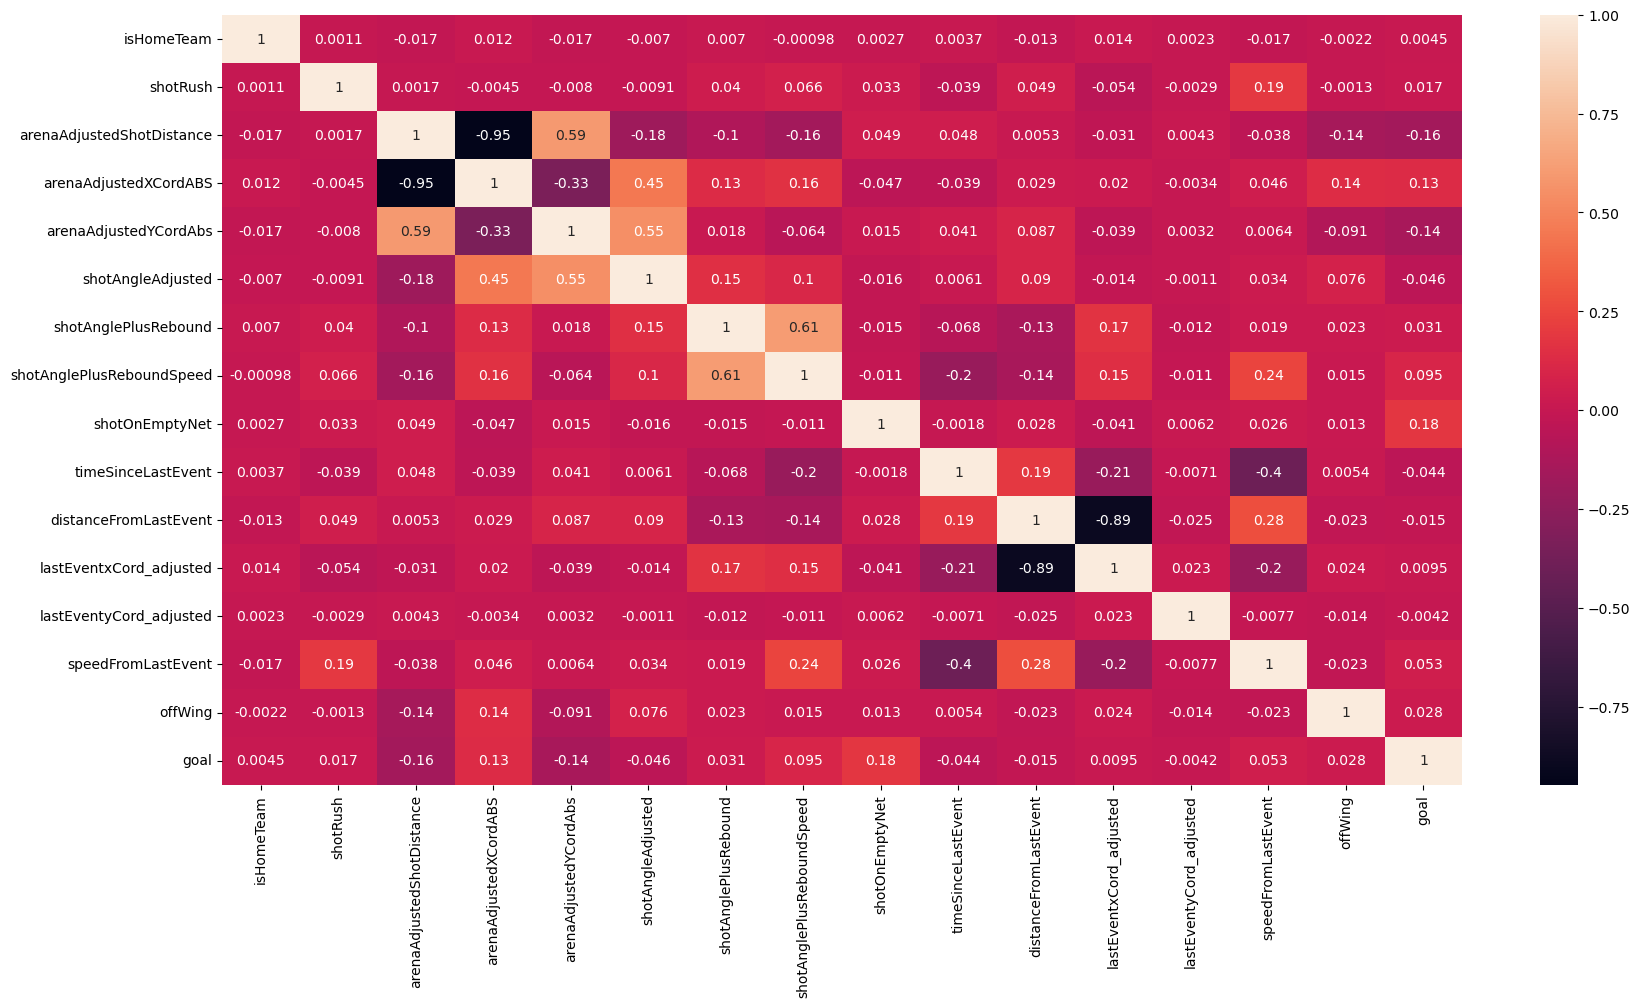

In [143]:
# Check correlation of selected features
plt.figure(figsize=(20,10))
cor = shots_df.corr()
sns.heatmap(cor, annot=True)
plt.show()

In [144]:
shots_df.corr().sort_values('goal')

,isHomeTeam,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal
arenaAdjustedShotDistance,-0.016761,0.001695,1.000000,-0.947619,0.590378,-0.182928,-0.100762,-0.157389,0.048856,0.047815,0.005268,-0.030524,0.004298,-0.038165,-0.143048,-0.159274
arenaAdjustedYCordAbs,-0.017398,-0.007993,0.590378,-0.334509,1.000000,0.547959,0.018225,-0.064065,0.014748,0.040926,0.087198,-0.039023,0.003242,0.006368,-0.090961,-0.140692
shotAngleAdjusted,-0.007015,-0.009066,-0.182928,0.446281,0.547959,1.000000,0.151187,0.103049,-0.016299,0.006107,0.090004,-0.013818,-0.001130,0.033653,0.075778,-0.046107
timeSinceLastEvent,0.003695,-0.039049,0.047815,-0.038922,0.040926,0.006107,-0.068224,-0.202267,-0.001849,1.000000,0.190687,-0.206977,-0.007057,-0.402057,0.005430,-0.043644
distanceFromLastEvent,-0.013339,0.049403,0.005268,0.028941,0.087198,0.090004,-0.130546,-0.138897,0.027952,0.190687,1.000000,-0.891811,-0.024569,0.284685,-0.022594,-0.014520
lastEventyCord_adjusted,0.002280,-0.002862,0.004298,-0.003381,0.003242,-0.001130,-0.012404,-0.010687,0.006188,-0.007057,-0.024569,0.022782,1.000000,-0.007732,-0.014137,-0.004205
isHomeTeam,1.000000,0.001061,-0.016761,0.012293,-0.017398,-0.007015,0.006989,-0.000976,0.002700,0.003695,-0.013339,0.014344,0.002280,-0.016954,-0.002152,0.004467
lastEventxCord_adjusted,0.014344,-0.054039,-0.030524,0.020229,-0.039023,-0.013818,0.169308,0.147170,-0.040889,-0.206977,-0.891811,1.000000,0.022782,-0.203705,0.024387,0.009483
shotRush,0.001061,1.000000,0.001695,-0.004502,-0.007993,-0.009066,0.039548,0.065869,0.032686,-0.039049,0.049403,-0.054039,-0.002862,0.188586,-0.001291,0.016706
offWing,-0.002152,-0.001291,-0.143048,0.135396,-0.090961,0.075778,0.022918,0.015478,0.012671,0.005430,-0.022594,0.024387,-0.014137,-0.023189,1.000000,0.027549


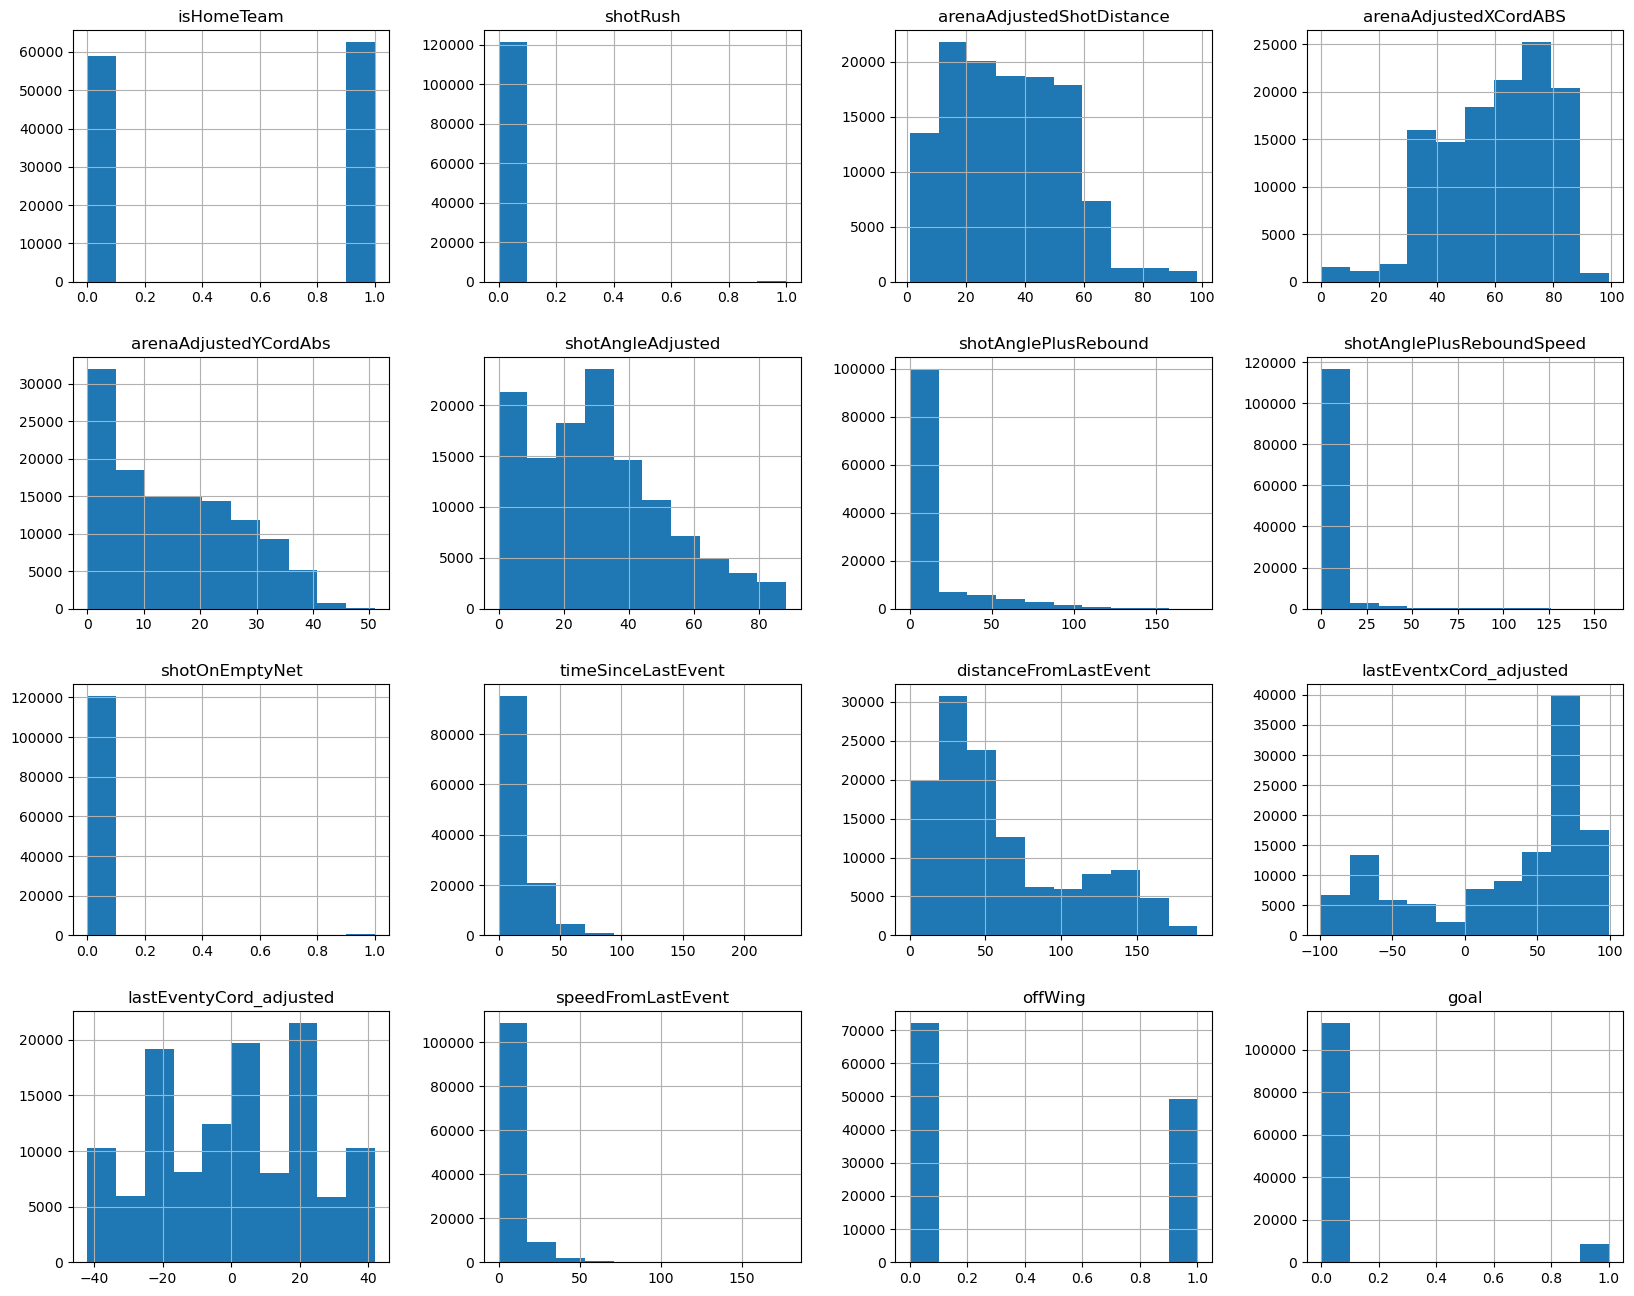

In [145]:
# Visualize features
shots_df.hist(bins=10, figsize=(20, 16))
plt.show()

## Baseline 

## Modeling 

### Build Pipeline

In [146]:
# Seperate target variable 'goal' from feature set
# and perform a stratified test_train_split due to high imbalance 
X = shots_df.drop(['goal'], axis = 1)
y = shots_df['goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

# Instantiate SMOTE

In [147]:
# Assign training sets of numeric and categorical columns to respective variables
num_features = X_train.select_dtypes(['int', 'float']).columns
cat_features = X_train.select_dtypes(['object']).columns

In [148]:
# declare scoring metrics
scoring = ['neg_log_loss', 'accuracy']

In [149]:
# Establish pipelines for each feature type
numeric_pipeline = Pipeline([('numnorm', StandardScaler())])

nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(handle_unknown = 'ignore')), 
    ('onehotnorm', MaxAbsScaler())])

In [150]:
# pass the pipelines to columntransformer
ct = ColumnTransformer(transformers=
    [("numpipe", numeric_pipeline, num_features),
     ("nominalpipe", nominal_pipeline, cat_features)])

In [151]:
ct 

ColumnTransformer(transformers=[('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                ('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(handle_unknown='ignore')),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 Index(['shotType', 'game_strength_state'], dtype='object'))])

In [152]:
num_features

Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')

In [153]:
# # get feature names after encoding
# feature_names = list(nominal_pipeline.named_steps['onehotenc'].fit(X_train[cat_features]).get_feature_names_out())

In [154]:
# import re
# # removes the OHE strings at front end of feature names
# def clean_ohe_names(feature_list):
#     extracted_names = []
#     for feature in feature_list:
#         match = re.search(r'_([^_]*)$', feature)
#         if match:
#             extracted_names.append(match.group(1))
#     return extracted_names

In [155]:
# cleaned_features = clean_ohe_names(feature_names)
# num_features_names = list(num_features)
# # put into a dataframe
# feature_names_df = pd.DataFrame(cleaned_features)
# # add the numerical cols at end of dataframe
# feature_names_df = feature_names_df.append(num_features_names)
# feature_names_df = feature_names_df.reset_index().drop(columns = 'index')

## Basic Logistic Regression Model

In [156]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = 42, max_iter=1000))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline.fit(X_train, y_train)

# Predict using the pipeline 
y_pred = base_log_reg_pipeline.predict(X_test)

In [157]:
# Evaluate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f'Test accuracy: {accuracy:.3f}')

# Calculate the F1 score for the test set
f1 = f1_score(y_test, y_pred,average='macro')
print(f'Test F1 score: {f1:.3f}')

# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

Test accuracy: 0.929
Test F1 score: 0.517
Test AUC-ROC score: 0.756
Test log loss score: 0.228


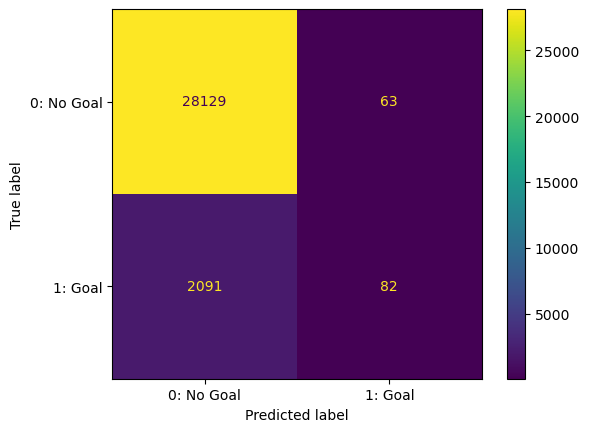

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.57      0.04      0.07      2173

    accuracy                           0.93     30365
   macro avg       0.75      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test log loss score: 0.228
Test AUC-ROC score: 0.756


In [158]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print(f'Classification report:\n{report}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, base_log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')

## Basic Random Forrest  Model

In [159]:
# build baseline trees pipeplin
steps = [('preprocess', ct), 
         ('etc', RandomForestClassifier(random_state = 42))]

rf_pipeline = Pipeline(steps)

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromLastEvent',
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('etc', RandomForestClassifier(random_state=42))])

In [160]:
pd.DataFrame(zip(feature_names_df[0].values,
                 rf_pipeline[1].feature_importances_)).sort_values(by = 1,
                                                                    ascending = False).head()

,0,1
13,6v4,0.113028
10,4v3,0.107194
5,WRAP,0.090000
2,SLAP,0.088823
12,5v4,0.085278


[0.01871086 0.00051871 0.08882334 0.07244553 0.06567016 0.08999989
 0.03701157 0.04160161 0.03043797 0.07866413 0.10719369 0.08501475
 0.08527828 0.11302796 0.01679768 0.00574589 0.00385071 0.005543
 0.00759338 0.00561467 0.00092799 0.01021217 0.00282026 0.0023274
 0.00765115 0.0011107  0.00181783 0.00564128 0.00081733 0.00256863
 0.00456148]


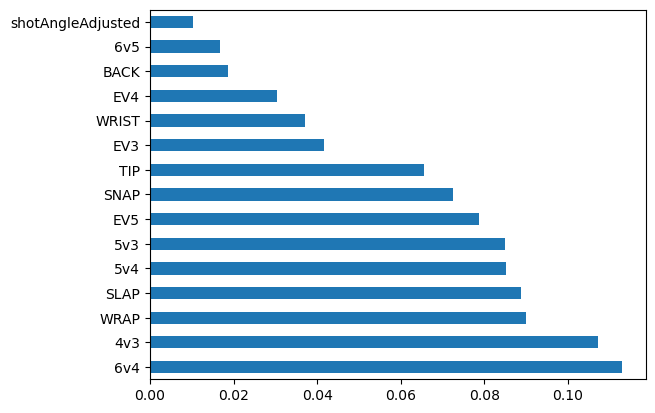

In [161]:
print(rf_pipeline[1].feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf_pipeline[1].feature_importances_, feature_names_df[0].values)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

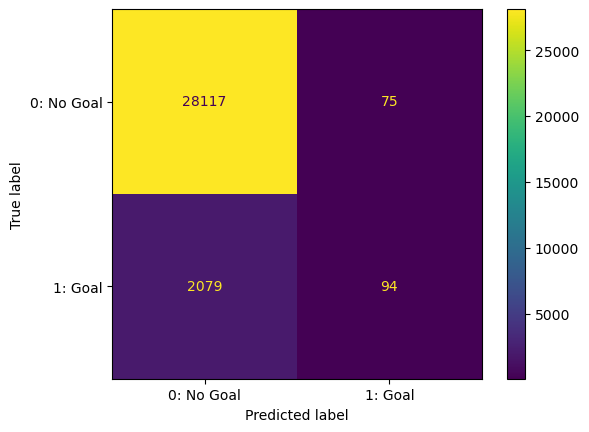

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.56      0.04      0.08      2173

    accuracy                           0.93     30365
   macro avg       0.74      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.737
Test log loss score: 0.287


In [162]:
# Predict using the pipeline 
y_pred_rf = rf_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_rf)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log-Loss score for the test set
log_loss_score = log_loss(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

In [163]:
rf_clf_smote

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromL...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('rf_clf', RandomForestClassifier())])

In [164]:
# RandomForestClassifier with smote
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
#          ('random', RandomOverSampler()),
         ('rf_clf', RandomForestClassifier())]

rf_clf_smote = Pipeline(steps)

rf_clf_smote.fit(X_train,y_train)
print('test: {}'.format(rf_clf_smote.score(X_test,y_test)))
print('train: {}'.format(rf_clf_smote.score(X_train,y_train)))

test: 0.9120368845710523
train: 0.9999780444161461


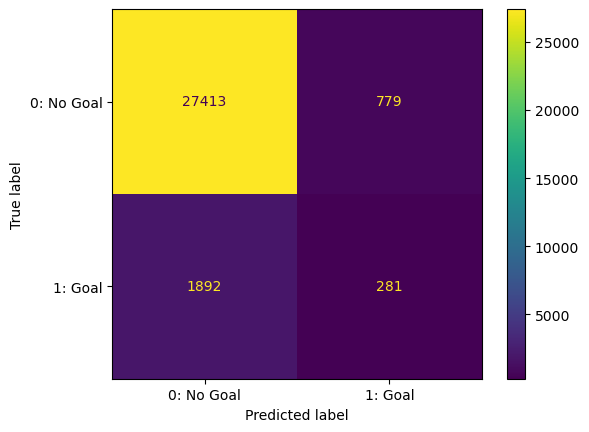

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.57      0.04      0.07      2173

    accuracy                           0.93     30365
   macro avg       0.75      0.52      0.52     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.731
Test log loss score: 0.298


In [165]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test,rf_clf_smote.predict(X_test))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, rf_clf_smote.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, rf_clf_smote.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')

## Cross Validated Logistic Regression with SMOTE

In [186]:
# Log CV
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
         ('logisticregression', LogisticRegression(max_iter = 10000))]

log_cv_pipeline = Pipeline(steps=steps)

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['saga','lbfgs'],
                'logisticregression__penalty': [None,'l2'],
                'logisticregression__C': [.05, 0.1,1]}

log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_params, cv=5, verbose=0, error_score='raise')

In [187]:
# log_cv = GridSearchCV(log_cv_pipeline, param_grid=log_params, cv=5, scoring=scoring, 
#                       refit = 'neg_log_loss', verbose=2, error_score='raise')

In [188]:
log_cv.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=saga; total time=   1.8s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=saga; total time=   1.8s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=saga; total time=   1.8s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=saga; total time=   1.9s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=saga; total time=   1.8s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=lbfgs; total time=   0.8s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logisticregression__solver=lbfgs; total time=   0.9s
[CV] END logisticregression__C=0.05, logisticregression__penalty=None, logis

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'sho...
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['shotType', 'game_strength_state'], dtype='object'))])),
                                       ('smote',
                                        SMOTE(sampling_strategy='minority')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.05, 0.1, 1],
                         'logisticregression__penalty': [None, 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']},
             verbose=2)

In [189]:
# print best params
log_cv.best_params_

{'logisticregression__C': 1,
 'logisticregression__penalty': None,
 'logisticregression__solver': 'lbfgs'}

In [190]:
# assign params to best_model
best_model = log_cv.best_estimator_.get_params()['logisticregression']

In [175]:
# log_cv.get_params()

{'cv': 5,
 'error_score': 'raise',
 'estimator__memory': None,
 'estimator__steps': [('preprocess',
   ColumnTransformer(transformers=[('numpipe',
                                    Pipeline(steps=[('numnorm',
                                                     StandardScaler())]),
                                    Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
          'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
          'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
          'timeSinceLastEvent', 'distanceFromLastEvent',
          'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
          'speedFromLastEvent', 'offWing'],
         dtype='object')),
                                   ('nominalpipe',
                                    Pipeline(steps=[('onehotenc',
                                                     OneHotEncoder(handle_unknown='ignore')),
                                                    

In [199]:
# Log Best Params w/o smote
steps = [('preprocess', ct),
#         ('smote', SMOTE(sampling_strategy='minority')),
        ('best_model', best_model)]

log_best_pipeline = Pipeline(steps=steps)
log_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromL...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('smote', SMOTE(sampling_strategy='minority')),
                ('best_model',
                 LogisticRegression(C=1, max_iter=10000, penalty=None))])

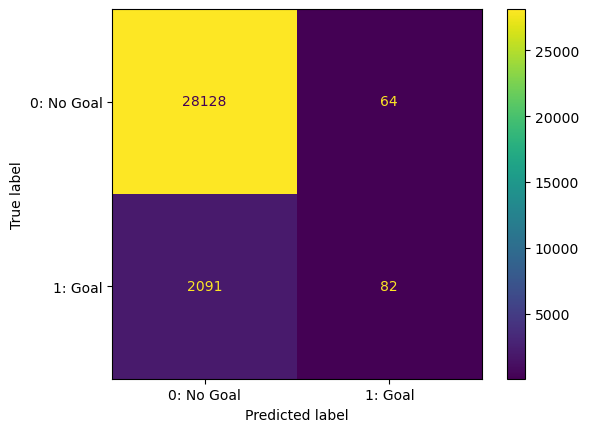

In [198]:
# Predict using the pipeline 
y_pred_log_cv = log_best_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_log_cv)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

In [195]:
print(log_best_pipeline.score(X_test, y_test))

0.9290301333772435


In [196]:
log_best_auc_roc = log_best_pipeline.score(X_test, y_test)
print(f'Test AUC-ROC score: {log_best_auc_roc:.3f}')
log_best_log_loss = log_loss(y_test, log_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_best_log_loss:.3f}')

Test AUC-ROC score: 0.929
Test log loss score: 0.228


In [ ]:
# Log Best Params w/ smote
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
        ('best_model', best_model)]

log_best_pipeline_smote = Pipeline(steps=steps)
log_best_pipeline_smote.fit(X_train, y_train)

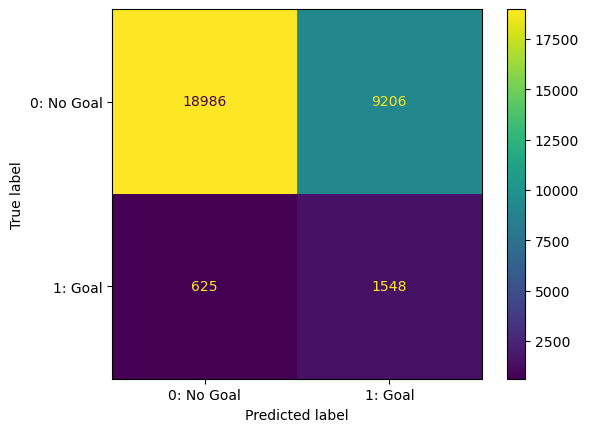

In [200]:
# with smote in steps
# Predict using the pipeline 
y_pred_log_cv_smote = log_best_pipeline_smote.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_log_cv_smote)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

In [201]:
log_best_auc_roc = log_best_pipeline_smote.score(X_test, y_test)
print(f'Test AUC-ROC score: {log_best_auc_roc:.3f}')
log_best_log_loss = log_loss(y_test, log_best_pipeline_smote.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_best_log_loss:.3f}')

Test AUC-ROC score: 0.676
Test log loss score: 0.585


## XGBoost

In [208]:
# XGBoost CV with smote
steps = [('preprocess', ct),
        ('smote', SMOTE(sampling_strategy='minority')),
#          ('random', RandomOverSampler()),
         ('gradient_booster', XGBClassifier())]

gb_pipeline = Pipeline(steps)

gb_params = {'gradient_booster__n_estimators': [50, 100, 250, 500], 
             'gradient_booster__learning_rate': [.001, .01, .1, 1], 
             'gradient_booster__max_depth': [3, 4, 5, 6]
            }

gb_cv = GridSearchCV(gb_pipeline, param_grid=gb_params, cv=2, verbose=0, error_score='raise',n_jobs=-1)

gb_cv.fit(X_train,y_train)
# print('test: {}'.format(gb_cv.score(X_test,y_test)))
# print('train: {}'.format(gb_cv.score(X_train,y_train)))

GridSearchCV(cv=2, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'sho...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'gradient_booster__learning_rate': [0.001, 0.01, 0.1,
                                                             1],
                         'gradient_booster__max_depth': [3, 4, 5, 6],
                         'gradient_booster__n_estimators': [50, 100, 250, 500]})

In [209]:
# get best parameters
print("Best parameters:", gb_cv.best_params_)

Best parameters: {'gradient_booster__learning_rate': 0.1, 'gradient_booster__max_depth': 4, 'gradient_booster__n_estimators': 500}


In [210]:
best_boost = gb_cv.best_estimator_.get_params()['gradient_booster']

In [212]:
# XGBoost Best Params
steps = [('preprocess', ct),
         ('smote', SMOTE(sampling_strategy='minority')),
         ('best_boost', best_boost)]

gb_best_pipeline = Pipeline(steps=steps)
gb_best_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromL...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='', learning_rate=0.1,
                               max_bin=256, max_cat_threshold=64,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=4, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=500, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, ...))])

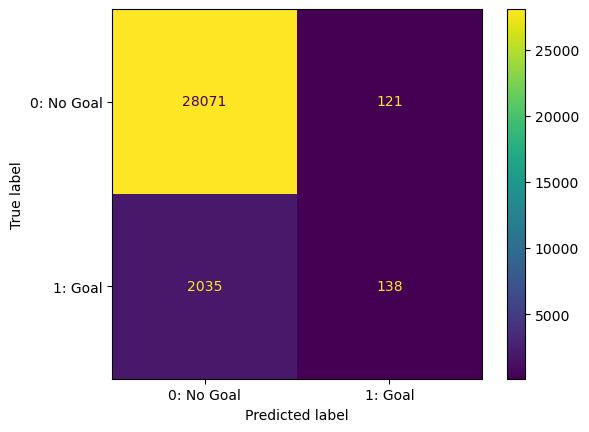

Classification report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     28192
           1       0.53      0.06      0.11      2173

    accuracy                           0.93     30365
   macro avg       0.73      0.53      0.54     30365
weighted avg       0.90      0.93      0.90     30365

Test AUC-ROC score: 0.736
Test log loss score: 0.245


In [215]:
# Predict using the pipeline 
y_pred_gb = gb_best_pipeline.predict(X_test)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test, y_pred_gb)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test, y_pred_gb)
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test, gb_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test, gb_best_pipeline.predict_proba(X_test)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set

## Create subset

In [216]:
# check goal values
shots_df['goal'].value_counts() # binary with 1 representing a goal scored

0    112766
1      8692
Name: goal, dtype: int64

In [218]:
# Take subset of majority class
goals_df = shots_df.loc[shots_df['goal'] == 1]

no_goals = shots_df.loc[shots_df['goal'] == 0].sample(shots_df['goal'].value_counts()[1])
df_sample = pd.concat([no_goals.reset_index(), goals_df.reset_index()],0)
df_sample.shape

(17384, 19)

In [219]:
df_sample= df_sample.drop('index',1)
df_sample

,isHomeTeam,shotType,shotRush,arenaAdjustedShotDistance,arenaAdjustedXCordABS,arenaAdjustedYCordAbs,shotAngleAdjusted,shotAnglePlusRebound,shotAnglePlusReboundSpeed,shotOnEmptyNet,timeSinceLastEvent,distanceFromLastEvent,lastEventxCord_adjusted,lastEventyCord_adjusted,speedFromLastEvent,offWing,goal,game_strength_state
0,0.0,SNAP,0,27.000000,68.0,17.0,37.694240,0.000000,0.000000,0,4,64.845971,5,36,16.211493,0,0,EV5
1,1.0,WRIST,0,39.623226,62.0,29.0,47.045408,28.610460,1.788154,0,16,26.832816,38,-17,1.677051,0,0,EV5
2,0.0,BACK,0,21.000000,83.0,20.0,73.739795,0.000000,0.000000,0,38,94.493386,9,36,2.486668,1,0,EV5
3,0.0,SLAP,0,61.000000,33.0,24.0,23.574706,0.000000,0.000000,0,6,35.057096,69,-22,5.842849,0,0,EV5
4,0.0,SLAP,0,42.000000,54.0,23.0,33.274888,0.000000,0.000000,0,8,88.192970,-20,22,11.024121,1,0,EV5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8687,1.0,WRIST,0,41.000000,59.0,28.0,42.954592,1.040322,1.040322,0,1,1.000000,60,-28,1.000000,0,1,EV5
8688,0.0,WRIST,0,31.000000,60.0,10.0,19.025606,0.000000,0.000000,0,45,129.556937,-69,-22,2.879043,1,1,EV5
8689,1.0,WRIST,0,10.049876,79.0,1.0,5.710593,0.000000,0.000000,0,2,17.691806,92,13,8.845903,1,1,EV5
8690,0.0,SNAP,0,23.706539,78.0,21.0,62.354025,0.000000,0.000000,0,6,80.777472,0,0,13.462912,1,1,PP_6v5


In [220]:
X_samp = df_sample.drop('goal',1)
y_samp = df_sample['goal']

In [221]:
X_train_sample,X_test_sample, y_train_sample, y_test_sample = train_test_split(X_samp,y_samp, random_state = 42)

### RandomForestClassifier on dataset sample

In [229]:
# RandomForestClassifier
steps = [('preprocess', ct),
         ('rf_clf', RandomForestClassifier())]

rf_clf_samp = Pipeline(steps)

rf_clf_samp.fit(X_train_sample,y_train_sample)
print('test: {}'.format(rf_clf_samp.score(X_test_sample,y_test_sample)))
print('train: {}'.format(rf_clf_samp.score(X_train_sample,y_train_sample)))

test: 0.6760239300506212
train: 1.0


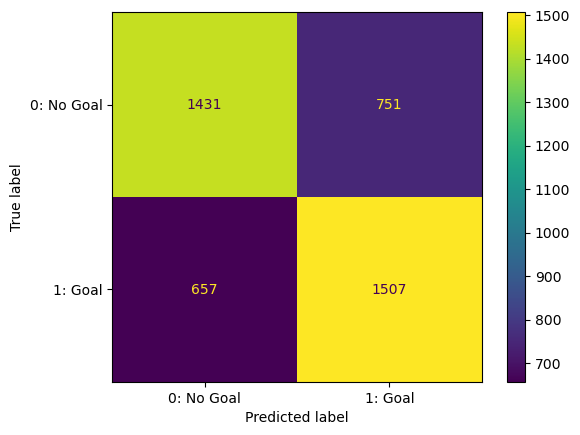

Classification report:
              precision    recall  f1-score   support

           0       0.69      0.66      0.67      2182
           1       0.67      0.70      0.68      2164

    accuracy                           0.68      4346
   macro avg       0.68      0.68      0.68      4346
weighted avg       0.68      0.68      0.68      4346

Test AUC-ROC score: 0.743
Test log loss score: 0.597


In [230]:
# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, rf_clf_samp.predict(X_test_sample))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

# Calculate and print the classification report
report = classification_report(y_test_sample, rf_clf_samp.predict(X_test_sample))
print(f'Classification report:\n{report}')
# Calculate the AUC-ROC score for the test set
auc_roc = roc_auc_score(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test AUC-ROC score: {auc_roc:.3f}')
# Calculate the Log Loss score for the test set
log_loss_score = log_loss(y_test_sample, rf_clf_samp.predict_proba(X_test_sample)[:, 1])
print(f'Test log loss score: {log_loss_score:.3f}')# Calculate the AUC-ROC score for the test set

### Logistic Regression CV on Data subset

In [231]:
# Log CV
steps = [('preprocess', ct),
         ('logisticregression', LogisticRegression(max_iter = 10000))]

sampled_log_cv_pipeline = Pipeline(steps=steps)

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['saga','lbfgs'],
                'logisticregression__penalty': [None,'l2'],
                'logisticregression__C': [.05, 0.1,1]}

sampled_log_cv = GridSearchCV(sampled_log_cv_pipeline, param_grid=log_params, cv=5, verbose=0, error_score='raise')

In [232]:
sampled_log_cv.fit(X_train_sample, y_train_sample)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('numpipe',
                                                                         Pipeline(steps=[('numnorm',
                                                                                          StandardScaler())]),
                                                                         Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'sho...
                                                                         Pipeline(steps=[('onehotenc',
                                                                                          OneHotEncoder(handle_unknown='ignore')),
                                                                                         ('onehotnorm',
                                                                                          MaxAbsScaler())]),
                                                                         Index(['shotType', 'game_strength_state'], dtype='object'))])),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'logisticregression__C': [0.05, 0.1, 1],
                         'logisticregression__penalty': [None, 'l2'],
                         'logisticregression__solver': ['saga', 'lbfgs']})

In [233]:
# print best params
sampled_log_cv.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'saga'}

In [234]:
# print best params
sampled_log_cv.best_params_

{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l2',
 'logisticregression__solver': 'saga'}

In [235]:
# assign params to best_model
sampled_best_model = sampled_log_cv.best_estimator_.get_params()['logisticregression']

In [236]:
# Log Best Params w/o smote
steps = [('preprocess', ct),
        ('sampled_best_model', sampled_best_model)]

sampled_best_pipeline = Pipeline(steps=steps)
sampled_best_pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['isHomeTeam', 'shotRush', 'arenaAdjustedShotDistance',
       'arenaAdjustedXCordABS', 'arenaAdjustedYCordAbs', 'shotAngleAdjusted',
       'shotAnglePlusRebound', 'shotAnglePlusReboundSpeed', 'shotOnEmptyNet',
       'timeSinceLastEvent', 'distanceFromL...
       'lastEventxCord_adjusted', 'lastEventyCord_adjusted',
       'speedFromLastEvent', 'offWing'],
      dtype='object')),
                                                 ('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(handle_unknown='ignore')),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['shotType', 'game_strength_state'], dtype='object'))])),
                ('sampled_best_model',
                 LogisticRegression(C=0.1, max_iter=10000, solver='saga'))])

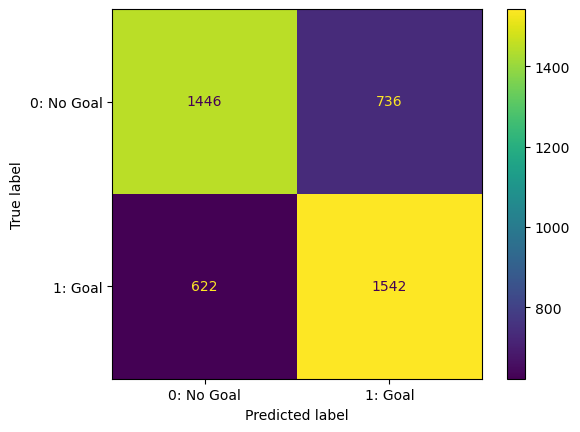

In [237]:
# Predict using the pipeline 
y_pred_log_cv_sampled = sampled_best_pipeline.predict(X_test_sample)

# Calculate the confusion matrix
label_names = ['0: No Goal', '1: Goal']
cm = confusion_matrix(y_test_sample, y_pred_log_cv_sampled)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot()
plt.show()

In [239]:
log_best_auc_roc = sampled_best_pipeline.score(X_test_sample, y_pred_log_cv_sampled)
print(f'Test AUC-ROC score: {log_best_auc_roc:.3f}')
log_best_log_loss = log_loss(y_test_sample, sampled_best_pipeline.predict_proba(X_test_sample)[:, 1])
print(f'Test log loss score: {log_best_log_loss:.3f}')

Test AUC-ROC score: 1.000
Test log loss score: 0.585
